<a href="https://colab.research.google.com/github/rocks2021/rockspython/blob/main/project_5_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5 Notes on Image Processing with Python
* Reading, displaying and saving an image by using PIL
* Reading, displaying and saving an image by using matplotlib
* Converting an image from png to jpg by using cv2
* Resizing
* Face morphing
* Seam carving

## Reading, Displaying and Saving an Image with PIL

In [1]:
import PIL
PIL.__version__

'8.1.0'

In [2]:
pip uninstall PIL

In [3]:
pip install Pillow==8.1.0

In [4]:
import PIL
PIL.__version__

'8.1.0'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from PIL import Image
deer = Image.open('/content/drive/My Drive/d.png')

In [7]:
print(deer.format, deer.mode, deer.size)

PNG RGB (500, 377)


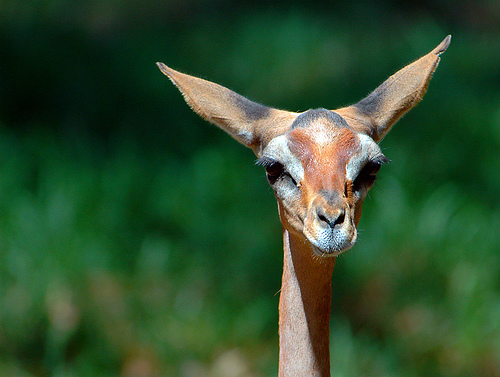

In [8]:
deer

In [9]:
deer_convert = deer.convert('RGB')
deer_convert.save('/content/drive/My Drive/deer.jpg')

In [10]:
deer_resize = deer.resize((deer.width//2, deer.height//2))
deer_resize.save('/content/drive/My Drive/deer_resize.jpg')

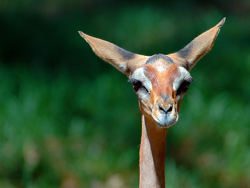

In [11]:
deer_resize

## Face morphing
* α-blending of two faces using cross-dissolving

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np

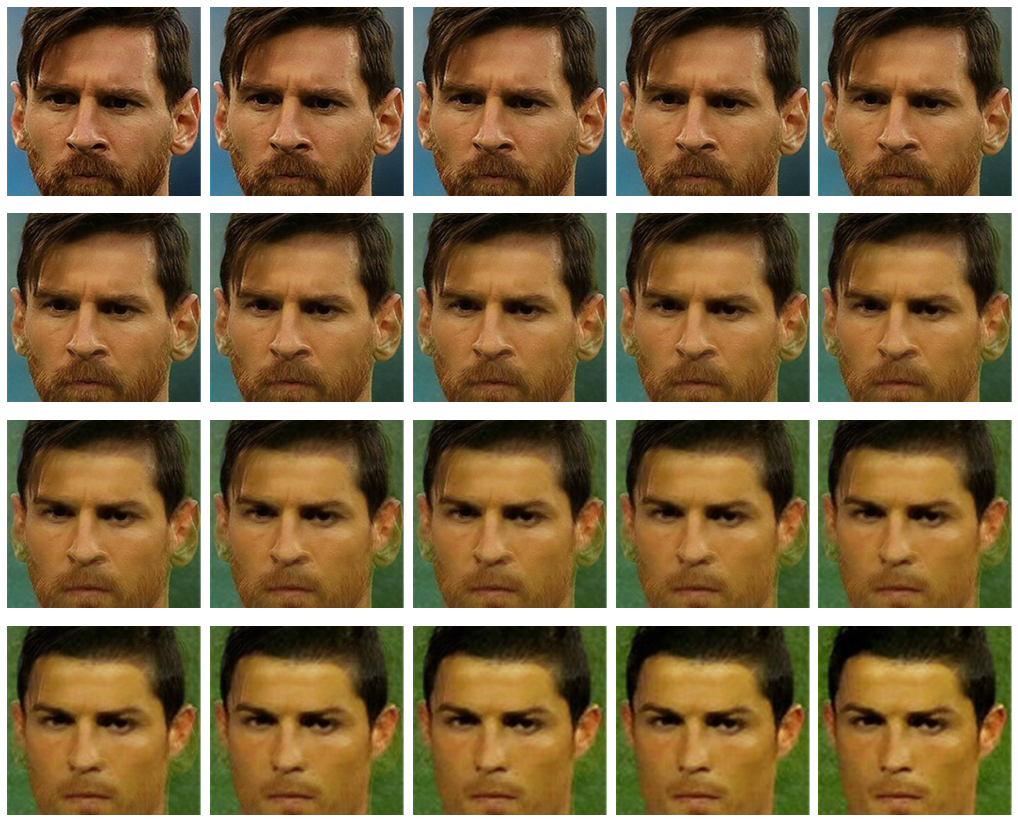

In [13]:
im1 = mpimg.imread('/content/drive/My Drive/messi.jpg') / 255 # scale RGB values in [0,1]
im2 = mpimg.imread('/content/drive/My Drive/ronaldo.jpg') / 255
i = 1
plt.figure(figsize=(18,15))
for alpha in np.linspace(0,1,20):
    plt.subplot(4,5,i)
    plt.imshow((1-alpha)*im1 + alpha*im2)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Seam Carving

In [14]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import numpy as np
from numba import jit
from tqdm import trange

In [15]:
d = cv2.imread('/content/drive/My Drive/d.png')
cv2.imwrite('d.jpg', d, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

True

(377, 500, 3) uint8 <class 'numpy.ndarray'>


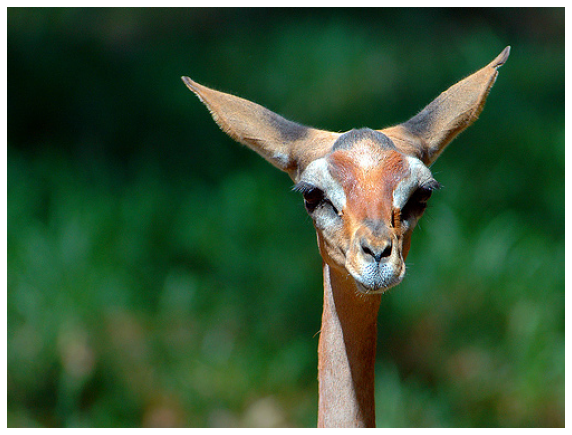

In [16]:
img = mpimg.imread('/content/drive/My Drive/d.jpg') 
print(img.shape, img.dtype, type(img))
plt.figure(figsize=(10,10))
plt.imshow(img) # display the image
plt.axis('off')
plt.show()

In [17]:
def display_map(img):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grayscale_img = cv2.GaussianBlur(grayscale_img,(7,7),0)

    laplacian = cv2.Laplacian(grayscale_img,cv2.CV_64F)
    abs_laplacian = cv2.convertScaleAbs(laplacian)
    imageMap = abs_laplacian

    plt.subplot(1,2,1),plt.imshow(img,cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(abs_laplacian,cmap = 'gray')
    plt.title('Laplacian'), plt.xticks([]), plt.yticks([])   
    plt.show()

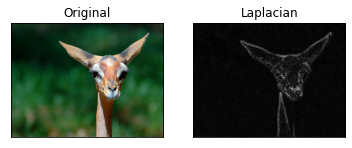

In [18]:
display_map(img)

In [19]:
@jit
def get_map(img):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grayscale_img = cv2.GaussianBlur(grayscale_img,(7,7),0)   
    laplacian = cv2.Laplacian(grayscale_img,cv2.CV_64F)
    abs_laplacian = cv2.convertScaleAbs(laplacian)
    imageMap = abs_laplacian   
    return imageMap

In [20]:
@jit
def min_seam(imageMap):    
    h,w = imageMap.shape[:2]   
    backtrack = np.zeros_like(imageMap, dtype=np.int)
    
    for i in range(1,h):
        for j in range(0,w):
            if j == 0:
                idx = np.argmin(imageMap[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = imageMap[i - 1, idx + j]
            else:
                idx = np.argmin(imageMap[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = imageMap[i - 1, idx + j - 1]

            imageMap[i, j] += min_energy

    return imageMap, backtrack

In [21]:
@jit
def carve_seam(image):
    h,w = image.shape[:2]    
    costMap,backtrack = min_seam(get_map(image))   
    deletionMask = np.ones((h,w), dtype=np.bool)
    
    j = np.argmin(costMap[-1])   
    for i in reversed(range(h)):
        deletionMask[i,j] = False
        j = backtrack[i,j]
    
    deletionMask = np.stack([deletionMask]*3,axis=2)   
    image = image[deletionMask].reshape((h,w-1,3))   
    return image

In [22]:
@jit
def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c):
        img = carve_seam(img)

    return img

<ipython-input-22-2356ed5a0cb7>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "crop_c" failed type inference due to: Untyped global name 'trange': cannot determine Numba type of <class 'function'>

File "<ipython-input-22-2356ed5a0cb7>", line 6:
def crop_c(img, scale_c):
    <source elided>

    for i in trange(c - new_c):
    ^

  @jit
<ipython-input-22-2356ed5a0cb7>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "crop_c" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-22-2356ed5a0cb7>", line 6:
def crop_c(img, scale_c):
    <source elided>

    for i in trange(c - new_c):
    ^

  @jit
/usr/local/lib/python3.6/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "crop_c" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-22-2356

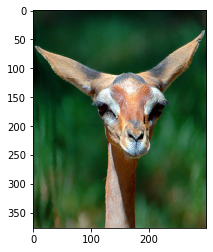

In [23]:
im_1 = crop_c(img, 0.6)
plt.imshow(im_1)